Ελευθέριος Μπόλκας 1115201900353

Η εργασία έγινε ατομικά.

Όλη η εργασία περιλαμβάνεται στο παρόν notebook. Οι συναρτήσεις του κώδικα περιέχονται επιπλέον και στα αρχεία του φακέλου src.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')


Για την εργασία θα χρησιμοποιηθούν 11410 tweets για να εκτελείται γρηγορότερα ο κώδικας. Αρχικά δημιουργούμε από το pickle αρχείο τα train.tsv και test.tsv:


In [4]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

def createTestAndTrain(infile, outTrain,outTest,percentage=1):
    df=pd.read_pickle(infile)
        
    df=df.sample(frac=percentage)
    (train_df,test_df)=train_test_split(df,test_size=0.2)
    train_df.to_csv(outTrain,sep="\t",index=False)
    test_df.to_csv(outTest,sep="\t",index=False)

    return df,train_df,test_df

#I have commented the following line which creates the files in order not to create different files in each run

#df,train_df,test_df=createTestAndTrain("/content/gdrive/MyDrive/Colab Notebooks/eclass_all_with_sentiment_v2.pkl","/content/gdrive/MyDrive/Colab Notebooks/train.tsv","/content/gdrive/MyDrive/Colab Notebooks/test.tsv",0.05)

#print(df.shape)
#print(train_df.shape)
#print(test_df.shape)

**1. Προεπεξαργασία και καθάρισμα δεδομένων**

Καθαρίζουμε αρχικά τη στήλη text των tweets. Αρχικά μετατρέπουμε τους κεφαλαίους χαρακτήρες σε μικρούς. Για τον καθαρισμό των σημείων στίξης, των hashtags,των links, των emoticons και των emojis χρησιμοποιείται η βιβλιοηθήκη re. Για την αφαίρεση των stopwords και για το lemmatization χρησιμοποιείται η βιβλιοθήκη nltk. 

In [ ]:
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
nltk.download('stopwords')
nltk.download('wordnet')

#Clean each strin from emoticons, emojis, symbols, hashtags, links, stopwords etc.
def cleanString(str):
    str=str.lower()
    
    #Remove hashtags
    str=re.sub(r"#\S+","",str)

    #Remove links
    str=re.sub(r"http\S+","",str)
    
    
    emojis= re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" u"\U000024C2-\U0001F251"  u"\U00010000-\U0010ffff" "]+",
                        flags=re.UNICODE )
    
    str=emojis.sub(r"",str)
    str=re.sub(r"[{}\[\]\|\\:;,.~`!@#\$%^&\*\(\)\+=\?/\'…’]+","",str)
    str=re.sub("\'\"","",str)
    str=re.sub(r"\s+"," ",str)
    str=re.sub(r" - "," ",str)
    
    #Lemmatization and removal of stop words
    lemmatizer = WordNetLemmatizer()
    str_list=[lemmatizer.lemmatize(word) for word in str.split() if word not in stopwords.words("english")]
    new_str=" ".join(str_list)
    str=new_str
    
    return str

#Clean the file
def cleanDf(file):
    df=pd.read_csv(file,sep="\t")
    df=df.astype({"text": str})
    df["text"]=df["text"].apply(cleanString)
    #Remove invalid tweets
    df=df.dropna(subset=["sentiment","retweets","date"])
    df=df.reset_index(drop=True)
    
    return df

df_train=cleanDf("/content/gdrive/MyDrive/Colab Notebooks/train.tsv")
df_test=cleanDf("/content/gdrive/MyDrive/Colab Notebooks/test.tsv")
df=pd.concat([df_train, df_test], ignore_index=True)

Μετά την προεπεξεργασία και τον καθαρισμό η στήλη text των δύο set φαίνονται παρακάτω:

In [6]:
print("\nText column of train set:\n")
print(df_train["text"])
print("\nText column of test set:\n")
print(df_test["text"])


Text column of train set:

0               double vaxxed baby 2 week want hug please
1       pincode 560011 covaxin dose 1 25 slot age 18 a...
2       greggwatson90 problem vaccine lot problem gov ...
3       560066 age 18 17-d1 0-d2 slot 18-06-2021 manip...
4                                          v burning aonh
                              ...                        
9122    ndtv update covaxin approval isnt narendramodi...
9123    pincode 560103 covaxin dose 1 20 slot age 18 a...
9124    receive 1 mn dos russia shot via russia busine...
9125    lol see price gone two came govt capped servic...
9126    briantylercohen repkatieporter everyone contin...
Name: text, Length: 9127, dtype: object

Text column of test set:

0       centre say current production capacity indigen...
1                   little research look like choice mass
2          anyone know gavinnewsom havent seen since took
3       strange duality dollyparton life near helped f...
4       production volume ramped 20

**2. Ανάλυση των δεδομένων**

**i.**

Στο παρακάτω ιστόγραμμα μπορούμε να δούμε την κατανομή των συναισθημάτων των tweets.


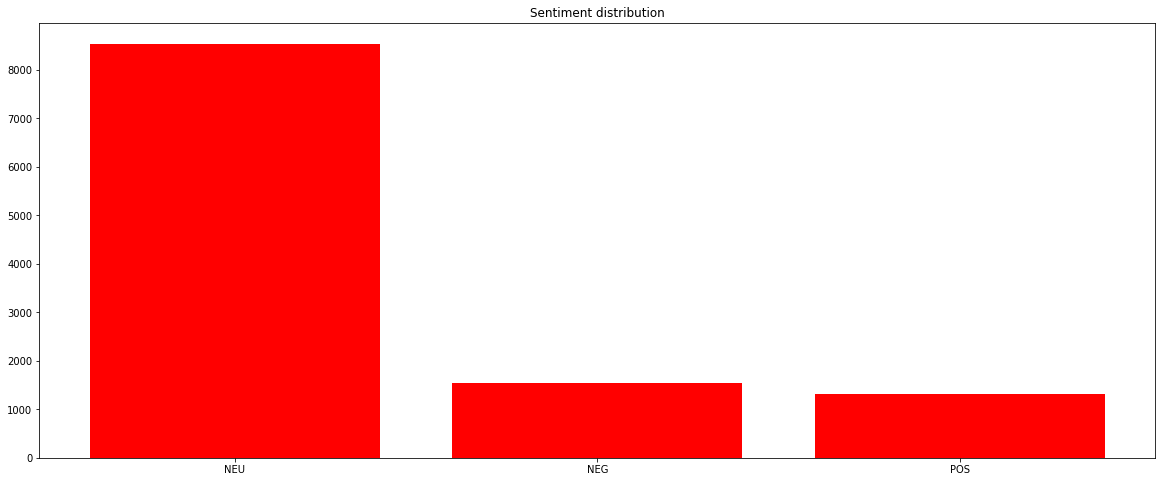

In [ ]:
def sent_distr(df):
    neu= df[df.sentiment=="NEU"].shape[0]
    neg= df[df.sentiment=="NEG"].shape[0]
    pos= df[df.sentiment=="POS"].shape[0]
    
    plt.bar(("NEU","NEG","POS"),(neu,neg,pos),color="r")
    plt.title("Sentiment distribution")
    plt.show()

sent_distr(df)

**ii.**

Στο παρακάτω διάγραμμα φαίνονται οι 20 πιο συχνές λέξεις στα tweets και το πλήθος τους 

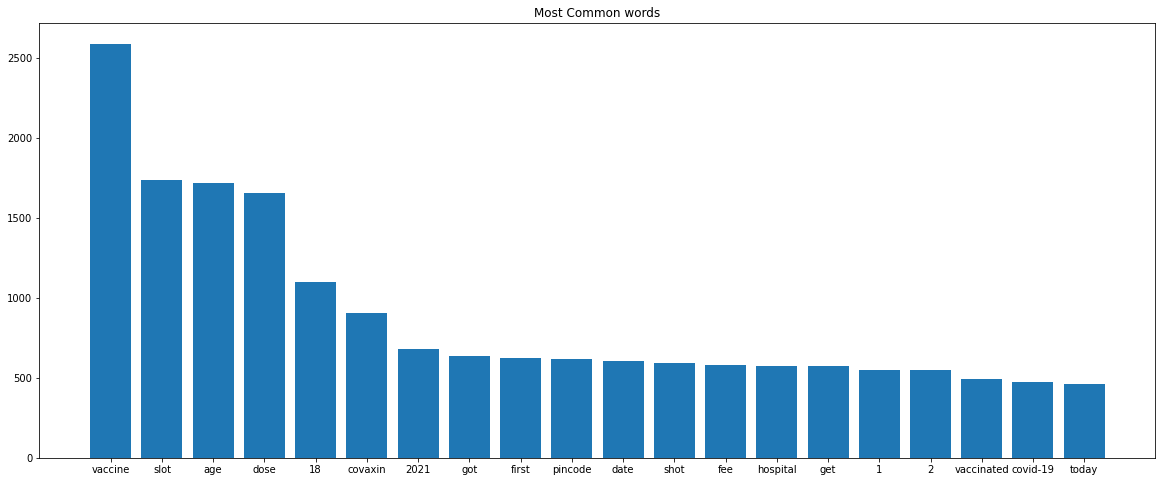

In [ ]:
def retKey(tup):
    return tup[1]

def word_freq(df):
    allWords=[x.split() for x in df["text"]]
    allWords=sum(allWords,[])
    
    dictWords=dict(Counter(allWords).most_common(20))
    comWords=list(dictWords.items())
    comWords.sort(reverse=True,key=retKey)
    plt.bar([x[0] for x in comWords],[x[1] for x in comWords])
    plt.title("Most Common words")
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.show()

word_freq(df)

**iii.**

Σε αυτό το διάγραμμα φαίνονται οι 20 πιο συχνές λέξεις σε κάθε κατηγορία tweets (ανά συναίσθημα) καθώς και το πλήθος τους. 

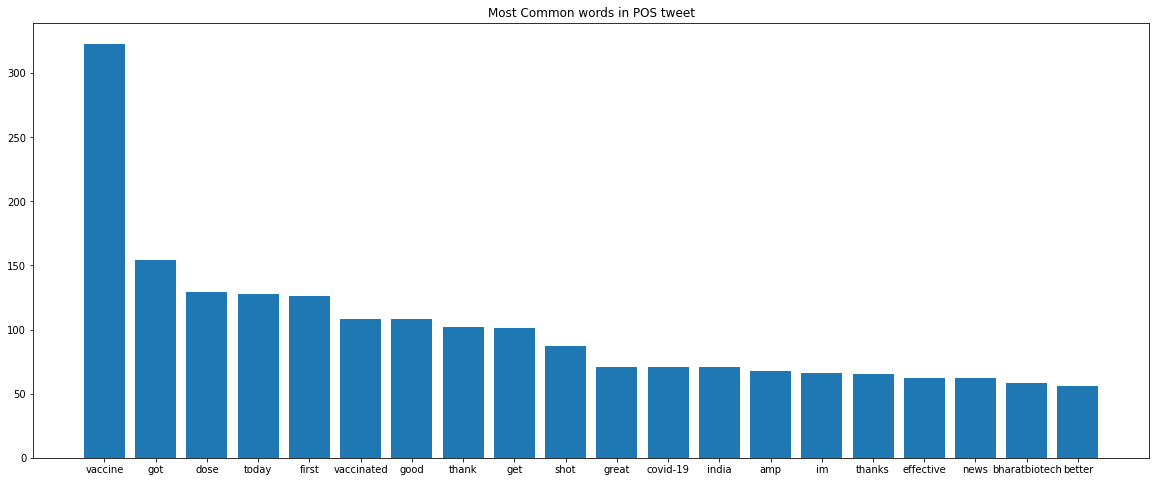

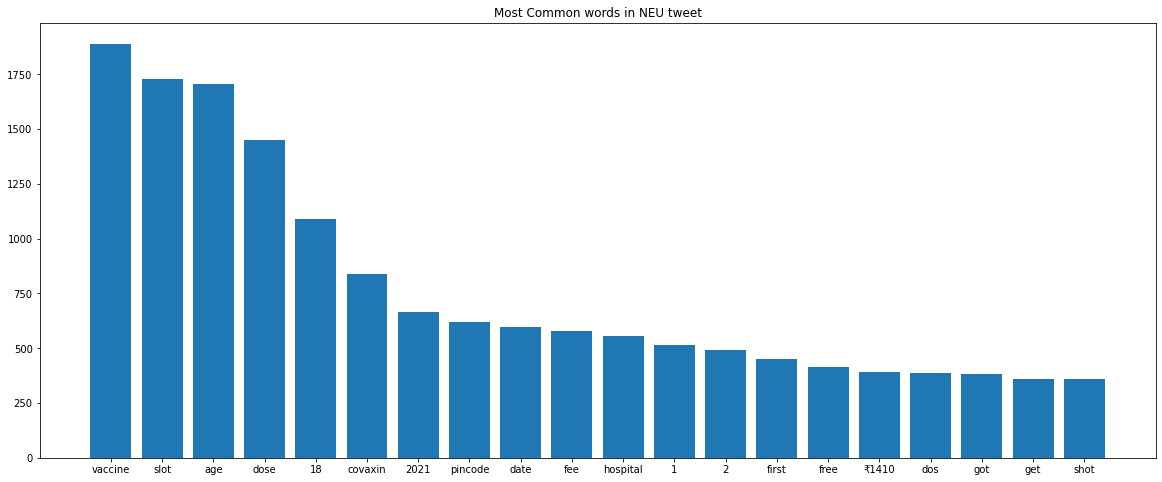

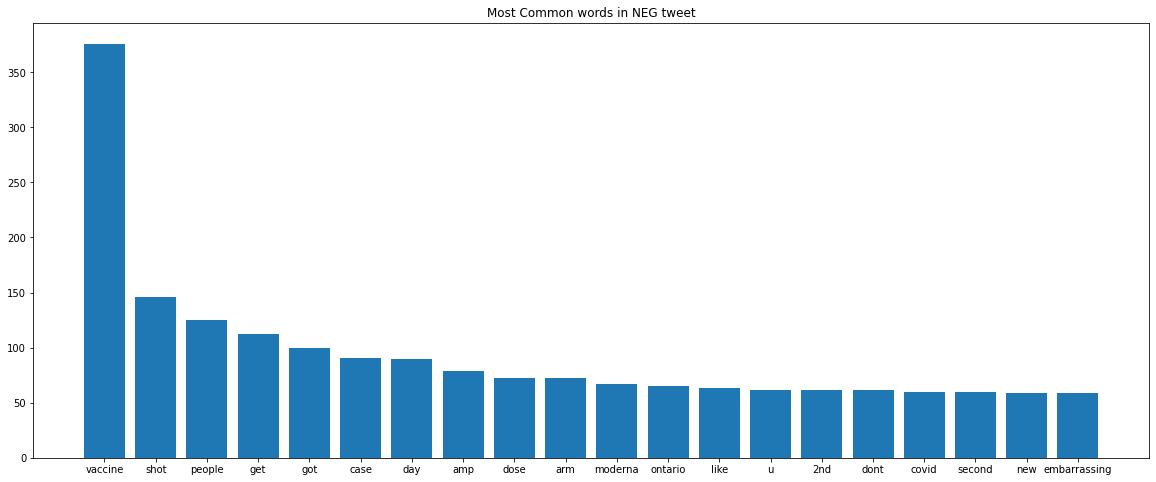

In [ ]:
def word_freq(df,sent=None):
    if sent==None:
        allWords=[x.split() for x in df["text"]]
    else:
        allWords=[df["text"].iloc[i].split() for i in range(df.shape[0]) if df["sentiment"].iloc[i]==sent]
    allWords=sum(allWords,[])
    
    dictWords=dict(Counter(allWords).most_common(20))
    comWords=list(dictWords.items())
    comWords.sort(reverse=True,key=retKey)
    plt.bar([x[0] for x in comWords],[x[1] for x in comWords])
    plt.title("Most Common words in "+sent+" tweet")
    plt.show()

word_freq(df,"POS")
word_freq(df,"NEU")
word_freq(df,"NEG")


**iv.**

Παρακάτω συγκρίνουμε ως προς το συναίσθημα τα tweets που περιέχουν τη λέξη astrazeneca και τα tweets που περιέχουν τις λέξεις pfizer/biontech και moderna(δηλαδή τα mrna εμβόλια). Η σύκριση γίνεται ως προς την ποσοστιαία κατανομή των συναισθημάτων των 2 υποσυνόλων. 

Όπως παρατηρούμε, το ποσοστό των tweets σχετικά με το astrazenca που έχουν θετικό συναίσθημα είναι μικρότερο από το αντίστοιχο ποσοστό των tweets σχετικά με τα mrna εμβόλια. Αντίστοιχα, το ποσοστό των tweets σχετικά με το astrazenca που έχουν αρνητικό συναίσθημα είναι μεγαλύτερο από το αντίστοιχο ποσοστό των tweets σχετικά με τα mrna εμβόλια.


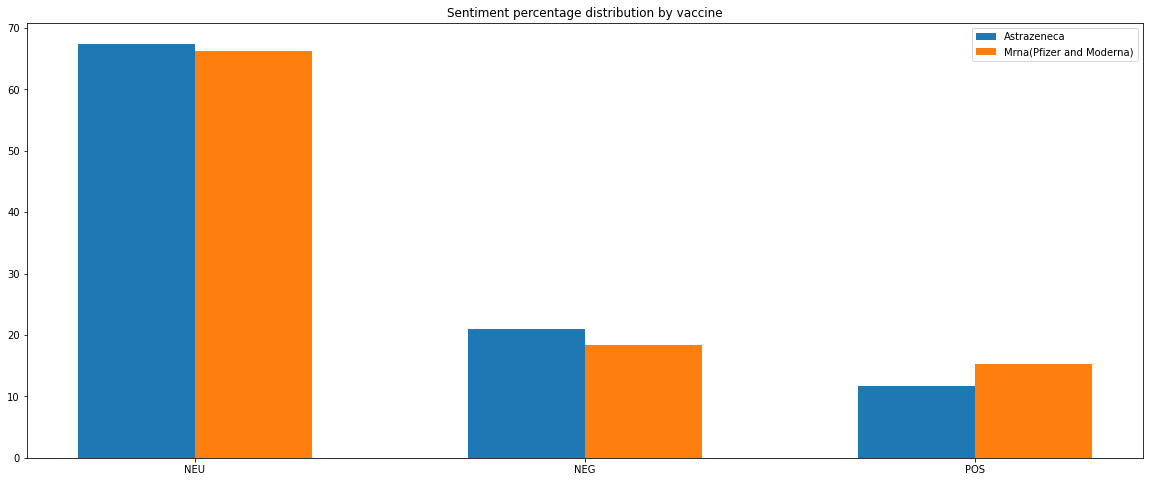

In [ ]:
def comp_astra_mrna(df):
    dfAstra=df[df.text.str.contains("astrazeneca")]
    dfMrna=df[df.text.str.contains("moderna|pfizer|biontech")]
    
    neuAstra= dfAstra[dfAstra.sentiment=="NEU"].shape[0]
    neuMrna= dfMrna[dfMrna.sentiment=="NEU"].shape[0]
    negAstra= dfAstra[dfAstra.sentiment=="NEG"].shape[0]
    negMrna= dfMrna[dfMrna.sentiment=="NEG"].shape[0]
    posAstra= dfAstra[dfAstra.sentiment=="POS"].shape[0]
    posMrna= dfMrna[dfMrna.sentiment=="POS"].shape[0]
    
    allAstra=neuAstra+negAstra+posAstra
    allMrna=neuMrna+negMrna+posMrna
    
    index = np.arange(3)
    
    fig, ax = plt.subplots()
    astra=ax.bar(index,100*np.array([neuAstra,negAstra,posAstra])/allAstra,0.3,label="Astrazeneca")
    mrna=ax.bar(index+0.3,100*np.array([neuMrna,negMrna,posMrna])/allMrna,0.3,label="Mrna(Pfizer and Moderna)")
    ax.set_xticks(index + 0.3 / 2)
    ax.set_xticklabels(["NEU","NEG","POS"])
    ax.set_title("Sentiment percentage distribution by vaccine")
    ax.legend()
    plt.show()

comp_astra_mrna(df)

**v.**

Το επόμενο διάγραμμα αναπαριστά το πλήθος των tweets που έγιναν ανά μήνα. 

Παρατηρούμε ότι υπάρχει μεγάλη άυξηση στο πλήθος των tweets το καλοκαίρι του 2021 και ιδιαίτερα τον Ιούνιο. Η αύξηση αυτή είναι λογική με βάση τα γεγονότα εκείνο τον καιρό. Πράγματι, εκείνη την εποχή, στις περισσότερες χώρες του κόσμου, τα εμβόλια έγιναν διαθέσιμα στο σύνολο του ενήλικου πληθυσμού χωρίς προϋποθέσεις. Ως αποτέλεσμα, ο κόσμος άρχισε να συζητά πολύ περισσότερο για αυτά.

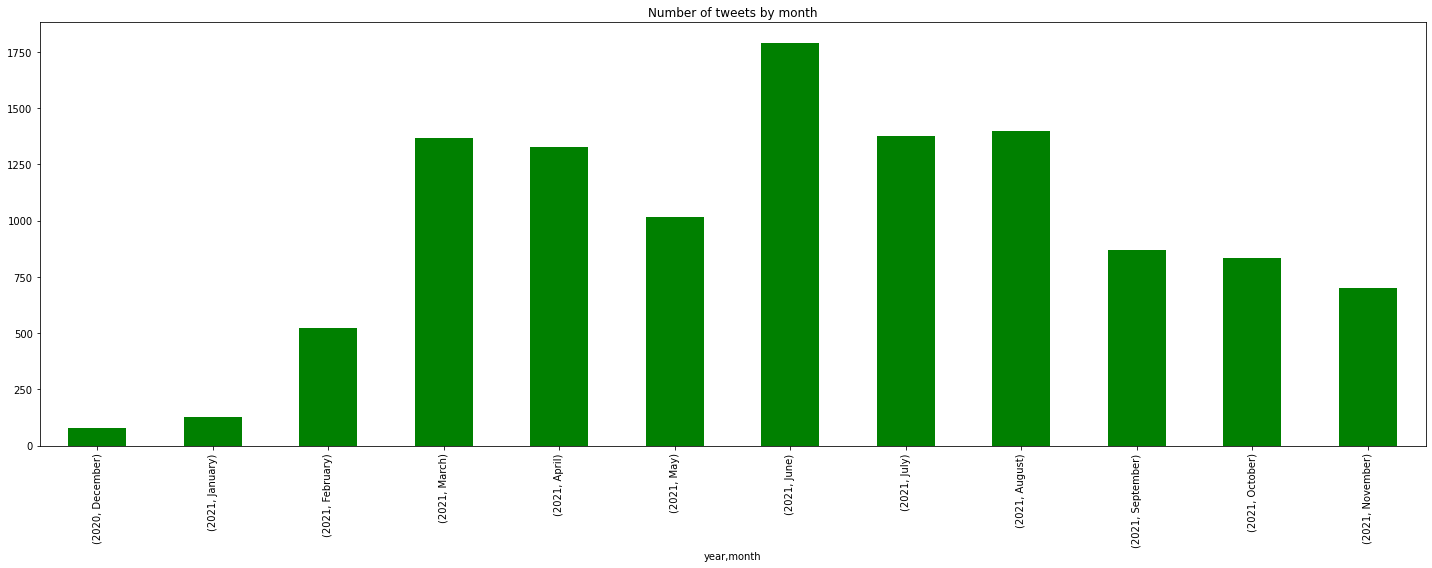

In [ ]:
def month_distr(df):
    copyDf=df.copy()
    copyDf = copyDf.astype({"date": "datetime64"})
    copyDf=copyDf.sort_values("date")
    copyDf=copyDf.groupby(
        [copyDf['date'].dt.year.rename('year'),copyDf['date'].dt.month_name().rename('month')],sort=False
        ).size().plot(kind="bar",color="green")
    plt.title("Number of tweets by month")
    plt.tight_layout()
    plt.show()

month_distr(df)

**vi.**

Παρακάτω παρουσιάζονται και 2 ακόμα παρατηρήσεις για τα tweets μαζί με τα αντίστοιχα γραφήματά τους.

Πρώτον, για να διαπιστωθεί η εξέλιξη του συναισθήματος του κόσμου σε σχέση με τα εμβόλια, δημιουργήθηκε το παρακάτω διάγραμμα το οποίο αναπαριστά τι ποσοστό των tweets είχαν αρνητικό συναίσθημα ανά μήνα. Από αυτό διαπιστώνουμε ότι το ποσοστό των tweets με αρνητικό συναίσθημα παρουσίασε μία μικρή μείωση μετά των πρώτο καιρό που βγήκαν τα εμβόλια. Ιδιαίτερα τους καλοκαιρινούς μήνες που έκαναν οι περισσότεροι τα εμβόλια, το ποσοστό των αρνητικών tweets ήταν πολύ μειωμένο. Μια πιθανή εξήγηση για αυτό είναι ότι τον πρώτο καιρό, πριν κάνουν πολλοί άνθρωποι το εμβόλιο, ο φόβος προς αυτό ενδέχεται να ήταν αυξημένος.

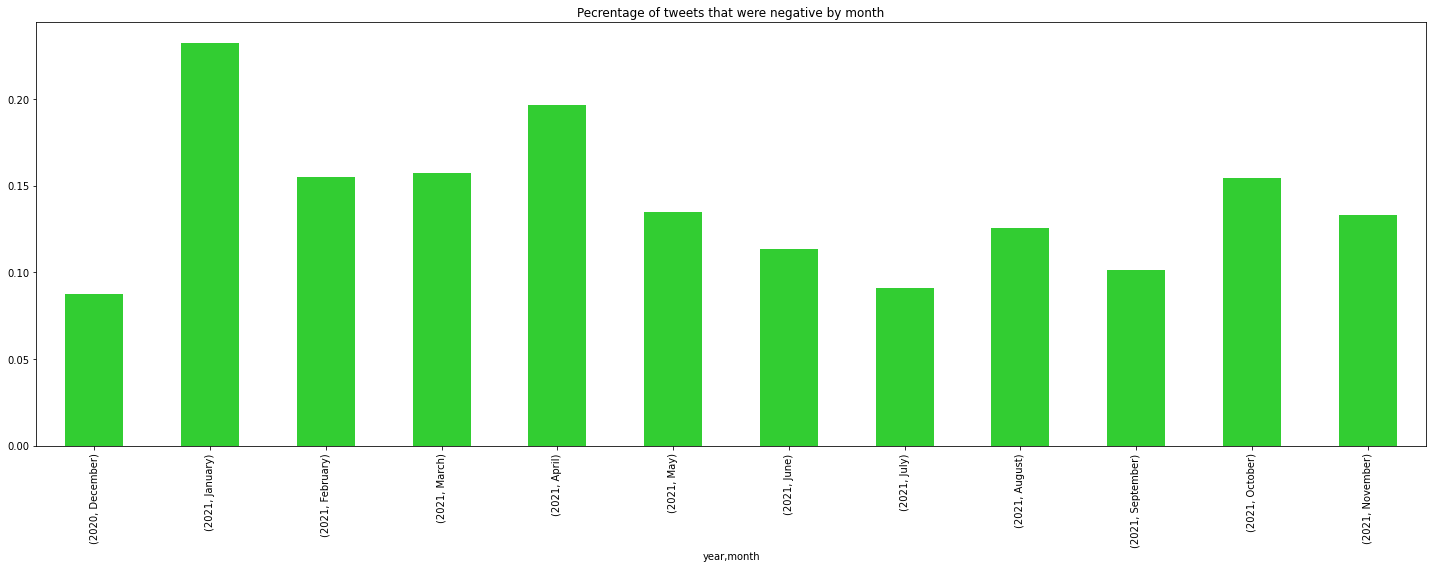

In [ ]:
def percent_positive_by_month(df):
    copyDf=df.copy()
    copyDf = copyDf.astype({"date": "datetime64"})
    copyDf=copyDf.sort_values("date")
    (copyDf[copyDf["sentiment"]=="NEG"].groupby(
        [copyDf['date'].dt.year.rename('year'),copyDf['date'].dt.month_name().rename('month')],sort=False
        ).size()/copyDf.groupby(
        [copyDf['date'].dt.year.rename('year'),copyDf['date'].dt.month_name().rename('month')],sort=False
        ).size()).plot(kind="bar",color="limegreen")
    plt.title("Pecrentage of tweets that were negative by month")
    plt.tight_layout()
    plt.show()

percent_positive_by_month(df)

Δεύτερον, εξετάστηκε τι ποσοστό των tweets σε κάθε κατηγορία(ανά συναίσθημα δηλαδή) έγινε τουλάχιστον μία φορά retweet. Διαπιστώνεται από το παρακάτω διάγραμμα, ότι η πιθανότητα ένα tweet να γίνει retweet ήταν παρόμοια, ανεξάρτητα από το συναίσθημα του tweet(το ποσοστό είναι λίγο μικρότερο στα ουδέτερα tweets, όπως ίσως θα περίμενε κανείς, αλλά η διαφορά δεν είναι στατιστικά σημαντική)

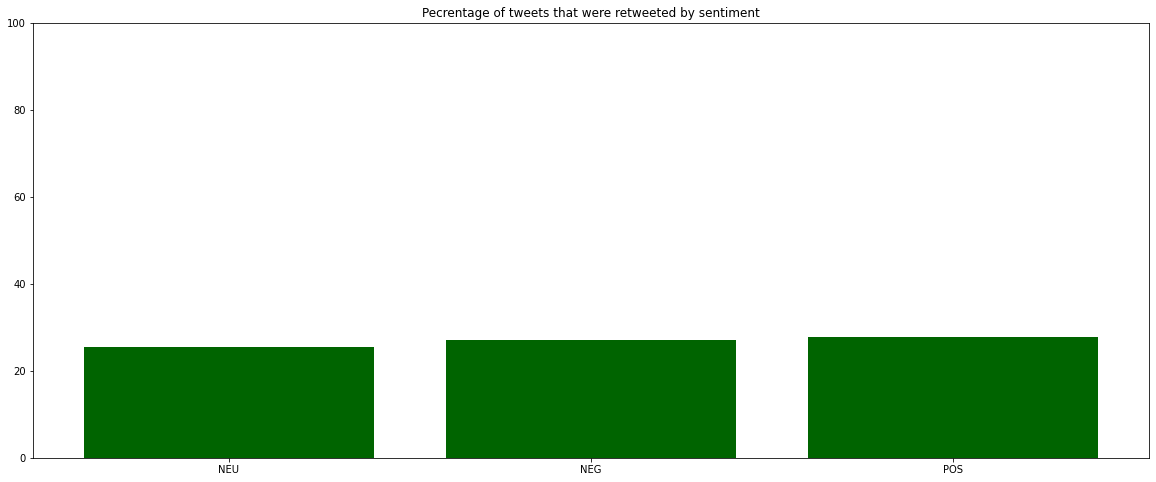

In [ ]:
def percent_retweets_by_sent(df):
    neu_perc= df[(df.sentiment=="NEU") & (df.retweets>0)].shape[0]/df[df.sentiment=="NEU"].shape[0]
    neg_perc= df[(df.sentiment=="NEG") & (df.retweets>0)].shape[0]/df[df.sentiment=="NEG"].shape[0]
    pos_perc= df[(df.sentiment=="POS") & (df.retweets>0)].shape[0]/df[df.sentiment=="POS"].shape[0]
    
    plt.bar(("NEU","NEG","POS"),(100*neu_perc,100*neg_perc,100*pos_perc),color="darkgreen")
    plt.ylim([0,100])
    plt.title("Pecrentage of tweets that were retweeted by sentiment")
    plt.show()

df=df.astype({"retweets": int})
percent_retweets_by_sent(df)

**3. Vectorization-Εξαγωγή χαρακτηριστικών**

In [ ]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Αρχικά φτιάχνουμε τα χαρακτηριστικά χρησιμοποιώντας bag-of-words

In [ ]:
#Bag-of-Words Vectorization
def bow_vect(df_train,df_test):
    bow_vectorizer=CountVectorizer(min_df=1,max_features=500,stop_words="english")
    
    xtrain_bow=bow_vectorizer.fit_transform(df_train["text"])
    xtest_bow=bow_vectorizer.transform(df_test["text"])

    pickle.dump((xtrain_bow.toarray(),xtest_bow.toarray()),open("/content/gdrive/MyDrive/Colab Notebooks/bow_vect.pkl",'wb'))
    
    return 

#I have commented the following in order not to calculate the features every time.
#bow_vect(df_train,df_test)
xtrain_bow,xtest_bow=pickle.load(open("/content/gdrive/MyDrive/Colab Notebooks/bow_vect.pkl",'rb'))

print(xtrain_bow.shape)
print(xtest_bow.shape)

(9127, 500)
(2282, 500)


Εδώ φτιάχνουμε τα χαρακτηριστικά χρησιμοποιώντας Tf-idf

In [ ]:
#Tf-idf Vectorization
def tfidf_vect(df_train,df_test):
    tfidf_vectorizer=TfidfVectorizer(max_features=500,stop_words="english")
    
    xtrain_tfidf=tfidf_vectorizer.fit_transform(df_train["text"])
    xtest_tfidf=tfidf_vectorizer.transform(df_test["text"])
    
    pickle.dump((xtrain_tfidf.toarray(),xtest_tfidf.toarray()),open("/content/gdrive/MyDrive/Colab Notebooks/tfidf_vect.pkl",'wb'))
    
    return

#I have commented the following in order not to calculate the features every time.
#tfidf_vect(df_train,df_test)
xtrain_tfidf,xtest_tfidf=pickle.load(open("/content/gdrive/MyDrive/Colab Notebooks/tfidf_vect.pkl",'rb'))

print(xtrain_tfidf.shape)
print(xtest_tfidf.shape)

(9127, 500)
(2282, 500)


Τέλος, κάνουμε το vectorization χρησιμοποιώντας Word-embeddings. Εδώ χρησιμοποιείται η βιβλιοθήκη gensim. Η συνάρτηση avg_vect υπολογίζει για ένα  tweet το μέσο όρο των διανυσμάτων που αντιστοιχούν στις λέξεις του tweet ώστε να πάρουμε ένα διάνυσμα για κάθε tweet.

In [ ]:
#Word Embeddings vectorization
def word2v_vect(df_train,df_test):
    tok_tweet=df_train["text"].apply(strsplit)
    model_w2v = gensim.models.Word2Vec(tok_tweet,min_count=2,sg = 1,negative = 10,workers= 2,seed=37,size=200)
    model_w2v.train(tok_tweet, total_examples= df.shape[0], epochs=20)
    
    xtrain_w2v=df_train["text"].apply(avg_vect,args=(model_w2v,))
    xtest_w2v=df_test["text"].apply(avg_vect,args=(model_w2v,))

    xtrain_array=np.array([xtrain_w2v.values[i] for i in range(xtrain_w2v.shape[0])],"float64")
    xtest_array=np.array([xtest_w2v.values[i] for i in range(xtest_w2v.shape[0])],"float64")

    #print(model_w2v.wv.most_similar(positive="pfizer")) #Print an example to see how word embeddings work

    pickle.dump((xtrain_array,xtest_array),open("/content/gdrive/MyDrive/Colab Notebooks/w2v_vect.pkl",'wb'))
    
    return 

#Calculate the average vector of a sentence
def avg_vect(str,model):
    if str=="":
        return np.random.uniform(-10,10,(200,)).astype("float64")

    str_list=str.split()
    vect_list=[model.wv[str_i] if str_i in model.wv
                    else np.random.uniform(-10,10,(200,)).astype("float64")
                for str_i in str_list]
                
    return np.array(sum(vect_list)/len(vect_list),"float64")

def strsplit(str):
    return str.split()


#I have commented the following in order not to calculate the features every time.
#word2v_vect(df_train,df_test)
xtrain_w2v,xtest_w2v=pickle.load(open("/content/gdrive/MyDrive/Colab Notebooks/w2v_vect.pkl",'rb'))

print(xtrain_w2v.shape)
print(xtest_w2v.shape)

(9127, 200)
(2282, 200)


**4. Ταξινομητές**

Αρχικά φτιάχνω μερικές συναρτήσεις οι οποίες χρησιμοποιούνται για να γίνει το 10-fold cross validation και για να αξιολογηθούν τα πιθανά μοντέλα. Για την αξιολόγηση, χρησιμοποιείται το classification_report παίρνοντας το μέσο όρο των αποτελεσμάτων των μετρικών στις 10 επαναλήψεις του cross validation.

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,accuracy_score,make_scorer
from sklearn.model_selection import cross_val_score

trainlabels=df_train["sentiment"].values
testlabels=df_test["sentiment"].values

true_values=[] #Keep here true values
pred_values=[] #Keep here predicted values

# Use this scorer to collect all the true values and predictions from the cross validation
def scoring_sum(y_true,y_pred):
    global true_values
    global pred_values
    true_values+=y_true.tolist()
    pred_values+=y_pred.tolist()
    return accuracy_score(y_true,y_pred)

#10-fold cross validation and evaluation
def cross_val_and_eval(model,xtrain,train_labels):
    global true_values
    global pred_values
    true_values=[]
    pred_values=[]
    kf = KFold(n_splits=10, shuffle=True)
    cross_val_score(model,xtrain,train_labels,cv=kf,scoring=make_scorer(scoring_sum))
    print(classification_report(true_values,pred_values))

Τώρα επιλέγουμε και αξιολογούμε τα καλύτερα μοντέλα χρσηιμοποιώντας 10-fold cross-validation. Κάθε μοντέλο που επιλέγεται, εκπαιδεύεται με τα διαφορετικά χαρακτηριστικά που έχουμε και γίνονται προβλέψεις στο σύνολο test. Η απόδοση με τις ζητούμενες μετρικές καταγράφεται παρακάτω μαζί με τη δημιουργία κάθε μοντέλου. Επιπλέον, συνολικά στο τέλος, παρατίθεται και ένα πινακάκι με την απόδοση κάθε μοντέλου-χαρακτηριστικών στο σύνολο test σαν ποσοστό των επιτυχών προβλέψεων ως προς το συνολικό πλήθος των προβλέψεων. 

**a)** Αρχικά φτιάχνουμε τον svm classifier. 

Για την επιλογή των καλύτερων παραμέτρων χρησιμοποιούνται οι συναρτήσεις παραπάνω που πραγματοποιούν 10-fold cross-validation και κάνουν την αξιολόγηση με τις ζητούμενες μετρικές. Τα χαρακτηριστικά που χρησιμοποιήθηκαν για την επιλογή δημιουργήθηκαν με bag-of-words. Παρακάτω τυπώνεται η απόδοση του καλύτερου μοντέλου που βρέθηκε. 

In [ ]:
clf_svm = svm.SVC(gamma=0.003, C=90.)
cross_val_and_eval(clf_svm,xtrain_bow,trainlabels)

              precision    recall  f1-score   support

         NEG       0.68      0.22      0.34      1236
         NEU       0.81      0.96      0.88      6848
         POS       0.69      0.41      0.51      1043

    accuracy                           0.80      9127
   macro avg       0.73      0.53      0.58      9127
weighted avg       0.78      0.80      0.77      9127



Έπειτα εκπαιδεύουμε τρεις ταξινομητές svm με τις παραμέτρους που επιλέχθηκαν παραπάνω χρησιμοποιώντας bag-of-words, tf-idf και word-embeddings αντίστοιχα και γίνονται οι αντίστοιχες προβλέψεις. (Το συγκριτικό πινακάκι με τις αποδόσεις των προβλέψεων βρίσκεται παρακάτω μετά τη δημιουργία όλων των μοντέλων.)

In [ ]:
def train_svm_clf(xtrain,trainlabels):
    clf_svm = svm.SVC(gamma=0.003, C=90.)
    clf_svm.fit(xtrain,trainlabels)
    return clf_svm

def test_svm_clf(xtest,model):
    return model.predict(xtest)

clf_svm_bow=train_svm_clf(xtrain_bow,trainlabels)
pred_sent_svm_bow=test_svm_clf(xtest_bow,clf_svm_bow)

clf_svm_tfidf=train_svm_clf(xtrain_tfidf,trainlabels)
pred_sent_svm_tfidf=test_svm_clf(xtest_tfidf,clf_svm_tfidf)

clf_svm_w2v=train_svm_clf(xtrain_w2v,trainlabels)
pred_sent_svm_w2v=test_svm_clf(xtest_w2v,clf_svm_w2v)

**b)** Ακολούθουμε τώρα την ίδια διαδικασία για τον Randoms Forests ταξινομητή. Φτιάχνουμε τον Randoms Forests classifier. 

Και πάλι για την επιλογή των καλύτερων παραμέτρων χρησιμοποιούνται οι συναρτήσεις παραπάνω που πραγματοποιούν 10-fold cross-validation και κάνουν την αξιολόγηση με τις ζητούμενες μετρικές. Τα χαρακτηριστικά που χρησιμοποιήθηκαν για την επιλογή δημιουργήθηκαν με bag-of-words. Παρακάτω τυπώνεται η απόδοση του καλύτερου μοντέλου που βρέθηκε. 

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=120)
cross_val_and_eval(random_forest_clf,xtrain_bow,trainlabels)

              precision    recall  f1-score   support

         NEG       0.50      0.33      0.39      1236
         NEU       0.82      0.92      0.87      6848
         POS       0.61      0.39      0.47      1043

    accuracy                           0.78      9127
   macro avg       0.64      0.54      0.58      9127
weighted avg       0.75      0.78      0.76      9127



Έπειτα εκπαιδεύουμε τρεις ταξινομητές random forests με τις παραμέτρους που επιλέχθηκαν παραπάνω χρησιμοποιώντας bag-of-words, tf-idf και word-embeddings αντίστοιχα και γίνονται οι αντίστοιχες προβλέψεις. (Το συγκριτικό πινακάκι με τις αποδόσεις των προβλέψεων βρίσκεται παρακάτω μετά τη δημιουργία όλων των μοντέλων.)

In [ ]:
def train_random_forest_clf(xtrain,trainlabels):
    random_forest_clf = RandomForestClassifier(n_estimators=120)
    random_forest_clf.fit(xtrain,trainlabels)
    return random_forest_clf

def test_random_forest_clf(xtest,model):
    return model.predict(xtest)

random_forest_clf_bow=train_random_forest_clf(xtrain_bow,trainlabels)
pred_sent_random_forest_bow=test_random_forest_clf(xtest_bow,random_forest_clf_bow)

random_forest_clf_tfidf=train_random_forest_clf(xtrain_tfidf,trainlabels)
pred_sent_random_forest_tfidf=test_random_forest_clf(xtest_tfidf,random_forest_clf_tfidf)

random_forest_clf_w2v=train_random_forest_clf(xtrain_w2v,trainlabels)
pred_sent_random_forest_w2v=test_random_forest_clf(xtest_w2v,random_forest_clf_w2v)

**c)** Τέλος, ακολούθουμε ξανά την ίδια διαδικασία για τον KNN ταξινομητή. Φτιάχνουμε τον KNN classifier. 

Κι εδώ για την επιλογή των καλύτερων παραμέτρων χρησιμοποιούνται οι συναρτήσεις παραπάνω που πραγματοποιούν 10-fold cross-validation και κάνουν την αξιολόγηση με τις ζητούμενες μετρικές. Τα χαρακτηριστικά που χρησιμοποιήθηκαν και πάλι για την επιλογή δημιουργήθηκαν με bag-of-words. Παρακάτω τυπώνεται η απόδοση του καλύτερου μοντέλου που βρέθηκε. 

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=6)
cross_val_and_eval(knn_clf,xtrain_bow,trainlabels)

              precision    recall  f1-score   support

         NEG       0.38      0.19      0.25      1236
         NEU       0.77      0.95      0.85      6848
         POS       0.61      0.07      0.12      1043

    accuracy                           0.75      9127
   macro avg       0.59      0.40      0.41      9127
weighted avg       0.70      0.75      0.69      9127



Έπειτα εκπαιδεύουμε τρεις ταξινομητές KNN με τις παραμέτρους που επιλέχθηκαν παραπάνω χρησιμοποιώντας bag-of-words, tf-idf και word-embeddings αντίστοιχα και γίνονται οι αντίστοιχες προβλέψεις. (Το συγκριτικό πινακάκι με τις αποδόσεις των προβλέψεων βρίσκεται παρακάτω μετά τη δημιουργία όλων των μοντέλων.)

In [ ]:
def train_knn_clf(xtrain,trainlabels):
    knn_clf = KNeighborsClassifier(n_neighbors=6)
    knn_clf.fit(xtrain,trainlabels)
    return knn_clf

def test_knn_clf(xtest,model):
    return model.predict(xtest)

knn_clf_bow=train_knn_clf(xtrain_bow,trainlabels)
pred_sent_knn_bow=test_knn_clf(xtest_bow,knn_clf_bow)

knn_clf_tfidf=train_knn_clf(xtrain_tfidf,trainlabels)
pred_sent_knn_tfidf=test_knn_clf(xtest_tfidf,knn_clf_tfidf)

knn_clf_w2v=train_knn_clf(xtrain_w2v,trainlabels)
pred_sent_knn_w2v=test_knn_clf(xtest_w2v,knn_clf_w2v)

Παράθετουμε τώρα, όπως αναφέρθηκε παραπάνω, ένα συγκριτικό πινακάκι με τις αποδόσεις όλων των μοντέλων στο σύνολο test εκπαιδευμένα με τα διαφορετικά χαρακτηριστικά. 

Βλέπουμε πως τα word embeddings έχουν τα χειρότερα αποτελέσματα(αντίθετα από το αναμενόμενο), ενώ τα καλύτερα αποτελέσματα έχουμε όταν χρησιμοποιούμε tf-idf. Χειρότερος ταξινομητής παρατηρούμε ότι είναι ο KNN(με τα word-embeddings όμως χειρότερος είναι ο svm), ενώ ο Random-Forests καταφέρνει να διατηρήσει υψηλή απόδοση με όλα τα χαρακτηριστικά.

In [ ]:
from tabulate import tabulate

def print_eff_results(list_clfs_res):
    table=[["Bag-of-Words","Tf-idf","Word Embeddings"],list_clfs_res[0],list_clfs_res[1],list_clfs_res[2]]
    print(tabulate(table,headers="firstrow", tablefmt="fancy_grid",showindex=["Svm","Random-Forest","Knn"]))

list_pred_clfs=[[pred_sent_svm_bow,pred_sent_svm_tfidf,pred_sent_svm_w2v],
           [pred_sent_random_forest_bow,pred_sent_random_forest_tfidf,pred_sent_random_forest_w2v],
           [pred_sent_knn_bow,pred_sent_knn_tfidf,pred_sent_knn_w2v]]

#For each classifier-characteristic, clalculate the percentage of correct predicted sentiments
list_clfs_res=[[sum([int(clf[charac][j]==testlabels[j]) for j in range(len(testlabels))])/len(testlabels) 
                        for charac in [0,1,2]] 
                            for clf in list_pred_clfs]

print_eff_results(list_clfs_res)

╒═══════════════╤════════════════╤══════════╤═══════════════════╕
│               │   Bag-of-Words │   Tf-idf │   Word Embeddings │
╞═══════════════╪════════════════╪══════════╪═══════════════════╡
│ Svm           │       0.788344 │ 0.783961 │          0.680105 │
├───────────────┼────────────────┼──────────┼───────────────────┤
│ Random-Forest │       0.754163 │ 0.773883 │          0.747152 │
├───────────────┼────────────────┼──────────┼───────────────────┤
│ Knn           │       0.73532  │ 0.746713 │          0.726117 │
╘═══════════════╧════════════════╧══════════╧═══════════════════╛


**5. Μοντελοποίηση θεμάτων LDA**

In [ ]:
import matplotlib.pyplot as plt
from gensim.test.utils import common_corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import *
from gensim.models import CoherenceModel
#!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

Τα βήματα για την επεξεργασία και τον καθαρισμό του κειμένου έχουν ήδη γίνει στο ερώτημα 1. Οπότε στην παρακάτω συνάρτηση, χρησιμοποιώντας πρώτα bag-of-words, δημιουργείται το μοντέλο χρησιμοποιώντας αρχικά 10 topics. Παράλληλα δημιουργείται το corpus και το dictionary από τα tweets.

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def lda(df,numTopics):
    tweets=[df["text"][i].split() for i in range(df.shape[0])]
    tweets_dictionary=Dictionary(tweets)
    tweets_corpus=[tweets_dictionary.doc2bow(tweet) for tweet in tweets]
    lda_model=LdaModel(tweets_corpus, num_topics=numTopics,id2word=tweets_dictionary)
    
    return lda_model,tweets_dictionary,tweets_corpus

lda_model,tweets_dictionary,tweets_corpus=lda(df,10)

Παρακάτω οπτικοποιούμε τα αποτελέσματα χρησιμοποιώντας τη βιβλιοθήκη pyLDAvis.

In [10]:
tweet_topics_vis=gensimvis.prepare(lda_model, tweets_corpus, tweets_dictionary)
pyLDAvis.display(tweet_topics_vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Τώρα θα βρούμε τον καλύτερο αριθμό θεμάτων υπολογίζοντας την μετρική topic coherence. Ο παρακατω κώδικας σχεδιάζει ένα γράφημα με την τιμή του coherence score ανάλογα με τον αριθμό των θεμάτων. Η παρακάτω συνάρτηση επιστρέφει επίσης τον αριθμό των θεμάτων για τον οποίο η μετρική παίρνει τη μέγιστη τιμή της.

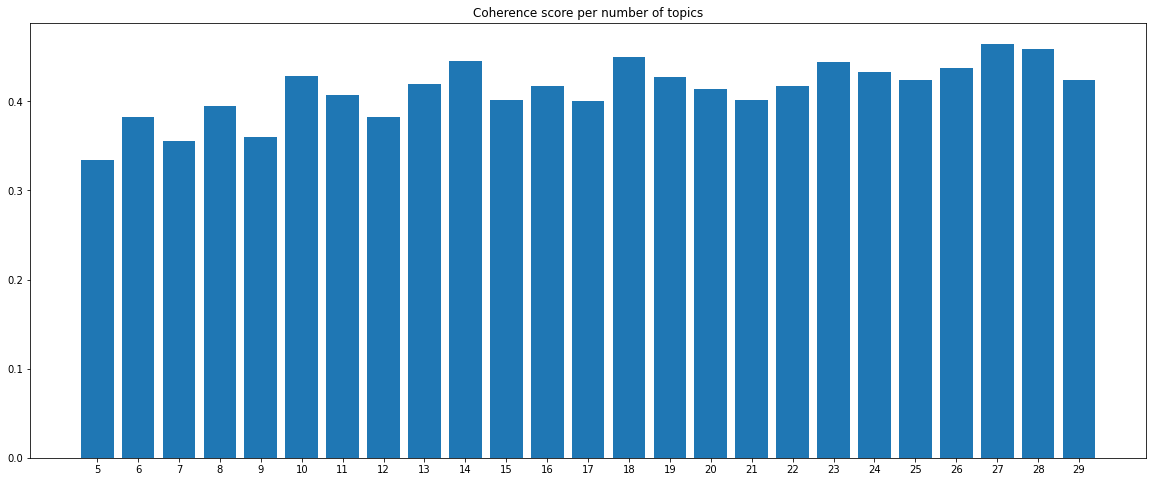

Best number of topics is 27


In [11]:
def eval_lda(df):
    tweets=[df["text"][i].split() for i in range(df.shape[0])]
    tweets_dictionary=Dictionary(tweets)
    tweets_corpus=[tweets_dictionary.doc2bow(tweet) for tweet in tweets]
    
    coherences=[]
    
    for i in range(5,30):
        lda_model=LdaModel(tweets_corpus, num_topics=i,id2word=tweets_dictionary)
        coh_lda_model=CoherenceModel(model=lda_model,dictionary=tweets_dictionary,texts=tweets,coherence="c_v")
        coherence=coh_lda_model.get_coherence()
        coherences.append(coherence)
    
    plt.bar(list(range(5,30)),coherences,tick_label=[str(i) for i in range(5,30)])
    plt.title("Coherence score per number of topics")
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.show()
        
    return coherences.index(max(coherences))

best_num_topics=5+eval_lda(df)
print("Best number of topics is",best_num_topics)

Τώρα για το βέλτιστο αριθμό θεμάτων που βρήκαμε, φτιάχνουμε το νέο LDA μοντέλο και οπτικοποιούμε τα αποτελέσματα.

In [12]:
lda_model,tweets_dictionary,tweets_corpus=lda(df,best_num_topics)
tweet_topics_vis=gensimvis.prepare(lda_model, tweets_corpus, tweets_dictionary)
pyLDAvis.display(tweet_topics_vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


**6. Beat the benchmark**

Εδώ δοκιμάζουμε κάποια επιπλέον χαρακτηριστικά για να βελτιώσουμε τα αποτελέσματα. Το lemmatization που ζητείται σε αυτό το ερώτημα έχει ήδη εφαρμοστεί από το πρώτο ερώτημα. Θα συγκριθούν μοντέλα που προκύπτουν από ταξινομητές svm χρησιμοποιώντας τα χαρακτηριστικά που έχουν προέλθει από την στήλη text με την bag-of-words μαζί με επιπλέον χαρακτηστικά.

Αρχικά δοκιμάζουμε προσθέσουμε το πλήθος των retweets στα χαρακτηριστικά.

In [ ]:
new_xtrain_retweets=np.concatenate((xtrain_bow,df_train["retweets"].to_numpy(dtype="float64").reshape(-1,1)),axis=1)
print(new_xtrain_retweets.shape)

new_xtest_retweets=np.concatenate((xtest_bow,df_test["retweets"].to_numpy(dtype="float64").reshape(-1,1)),axis=1)
print(new_xtest_retweets.shape)

(9127, 501)
(2282, 501)


Εκπαιδεύουμε τώρα το τα μοντέλα(svm,random-forests,knn) και κάνουμε τις προβλέψεις στο test dataset.

In [ ]:
clf_svm_retweets=train_svm_clf(new_xtrain_retweets,trainlabels)
pred_sent_svm_retweets=test_svm_clf(new_xtest_retweets,clf_svm_retweets)

clf_random_forest_retweets=train_random_forest_clf(new_xtrain_retweets,trainlabels)
pred_sent_random_forest_retweets=test_random_forest_clf(new_xtest_retweets,clf_random_forest_retweets)

clf_knn_retweets=train_knn_clf(new_xtrain_retweets,trainlabels)
pred_sent_knn_retweets=test_knn_clf(new_xtest_retweets,clf_knn_retweets)

Σχεδιάζουμε τώρα ένα πινακάκι για να συγκρίνουμε τα αποτελέσματα με τα επιπλέον χαρακτηριστικά σε σχέση με τα αρχικά. Η απόδοση εδώ υπολογίζεται ως το ποσοστό των πετυχημένων προβλέψεων. Όπως μπορούμε να δούμε, συμπεριλαμβάνοντας των πλήθος των retweets στα χαρακτηριστικά, υπάρχει μία μικρή βελτίωση στα αποτελέσματα, η οποία όμως δεν είναι σημαντική.

In [ ]:
list_pred_clfs_retweets=[pred_sent_svm_retweets, pred_sent_random_forest_retweets, pred_sent_knn_retweets]

#For each classifier, calculate the percentage of correct predicted sentiments
list_clfs_res_retweets=[sum([int(clf[j]==testlabels[j]) for j in range(len(testlabels))])/len(testlabels) 
                            for clf in list_pred_clfs_retweets]

table_retweets=[["Svm","Random-Forest","Knn"],[list_clfs_res[0][0],list_clfs_res[1][0],list_clfs_res[2][0]],list_clfs_res_retweets]
print(tabulate(table_retweets,headers="firstrow", tablefmt="fancy_grid",showindex=["No extra characteristic","Number of retweets"]))

╒═════════════════════════╤══════════╤═════════════════╤══════════╕
│                         │      Svm │   Random-Forest │      Knn │
╞═════════════════════════╪══════════╪═════════════════╪══════════╡
│ No extra characteristic │ 0.788344 │        0.754163 │ 0.73532  │
├─────────────────────────┼──────────┼─────────────────┼──────────┤
│ Number of retweets      │ 0.785714 │        0.765118 │ 0.745399 │
╘═════════════════════════╧══════════╧═════════════════╧══════════╛


Εδώ θα δοκιμάσουμε να προσθέσουμε κάποια πληοροφορία σε σχέση με το χρήστη που έκανε το tweet. Συγκεκριμένα θα προσθέσουμε το πλήθος των followers που έχει ο χρήστης.

In [ ]:
new_xtrain_followers=np.concatenate((xtrain_bow,df_train["user_followers"].to_numpy(dtype="float64").reshape(-1,1)),axis=1)
print(new_xtrain_followers.shape)

new_xtest_followers=np.concatenate((xtest_bow,df_test["user_followers"].to_numpy(dtype="float64").reshape(-1,1)),axis=1)
print(new_xtest_followers.shape)

(9127, 501)
(2282, 501)


Εκπαιδεύουμε τώρα το τα μοντέλα(svm,random-forests,knn) και κάνουμε τις προβλέψεις στο test dataset.

In [ ]:
clf_svm_followers=train_svm_clf(new_xtrain_followers,trainlabels)
pred_sent_svm_followers=test_svm_clf(new_xtest_followers,clf_svm_followers)

clf_random_forest_followers=train_random_forest_clf(new_xtrain_followers,trainlabels)
pred_sent_random_forest_followers=test_random_forest_clf(new_xtest_followers,clf_random_forest_followers)

clf_knn_followers=train_knn_clf(new_xtrain_followers,trainlabels)
pred_sent_knn_followers=test_knn_clf(new_xtest_followers,clf_knn_followers)

Σχεδιάζουμε πάλι τώρα ένα πινακάκι για να συγκρίνουμε τα αποτελέσματα με τα επιπλέον χαρακτηριστικά σε σχέση με τα αρχικά. Η απόδοση εδώ υπολογίζεται ως το ποσοστό των πετυχημένων προβλέψεων. Εδώ μπορούμε να παρατηρήσουμε ότι όχι μόνο δεν υπάρχει βελτίωση, αλλά η απόδοση είναι στην πραγματικότητα χειρότερη.

In [ ]:
list_pred_clfs_followers=[pred_sent_svm_followers, pred_sent_random_forest_followers, pred_sent_knn_followers]

#For each classifier, calculate the percentage of correct predicted sentiments
list_clfs_res_followers=[sum([int(clf[j]==testlabels[j]) for j in range(len(testlabels))])/len(testlabels) 
                            for clf in list_pred_clfs_followers]

table_followers=[["Svm","Random-Forest","Knn"],[list_clfs_res[0][0],list_clfs_res[1][0],list_clfs_res[2][0]],list_clfs_res_followers]
print(tabulate(table_followers,headers="firstrow", tablefmt="fancy_grid",showindex=["No extra characteristic","Number of followers"]))

╒═════════════════════════╤══════════╤═════════════════╤═════════╕
│                         │      Svm │   Random-Forest │     Knn │
╞═════════════════════════╪══════════╪═════════════════╪═════════╡
│ No extra characteristic │ 0.788344 │        0.754163 │ 0.73532 │
├─────────────────────────┼──────────┼─────────────────┼─────────┤
│ Number of followers     │ 0.736635 │        0.760298 │ 0.71078 │
╘═════════════════════════╧══════════╧═════════════════╧═════════╛


**Συμπέρασμα**

Η απόδοση των μοντέλων με τα αρχικά χαρακτηριστικά που είχαν χρησιμοποιηθεί ήταν αρκετά καλή(>70% πετυχημένες προβλέψεις με τα περισσότερα μοντέλα). Τα επιπλέον χαρακτηριστικά που δοκιμάστηκαν δεν βελτίωσαν σημαντικά την απόδοση των μοντέλων, αν και υπήρξε μία βελτίωση χρησιμοποιώντας τον αριθμό των retweets. Οπότε για το επιλεγμένο μας μοντέλο θα μπορούσαμε να χρησιμοποιήσουμε αυτή την επιπλέον πληροφορία. Για παράδειγμα, ο συνδυασμός svm και bag-of-words ή tf-idf συμπεριλαμβάνοντας το πλήθος των retweets προσφέρει ικανοποιητικά αποτελέσματα.